In [1]:
import numpy as np
import cv2
import os
from skimage.color import rgb2lab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = 256  # Image size for resizing
BATCH_SIZE = 32  # Batch size for training
MAX_IMAGES = 2000  # Maximum number of images to load

# Function to load and preprocess images
def load_images_from_folder(folder, max_images=MAX_IMAGES):
    images = []
    count = 0
    for filename in os.listdir(folder):
        if count >= max_images:
            break
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            count += 1
    return np.array(images)

# Load images
color_images = load_images_from_folder("/kaggle/input/landscape-image-colorization/landscape Images/color")
gray_images = load_images_from_folder("/kaggle/input/landscape-image-colorization/landscape Images/gray")

# Convert to LAB color space and separate channels
X = np.array([rgb2lab(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[:, :, 0] for img in color_images])  # L channel
Y = np.array([rgb2lab(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))[:, :, 1:] for img in color_images])  # AB channels

# Normalize the data
X = X / 100.0  # L channel range: [0, 100]
Y = (Y + 128) / 255.0  # AB channels range: [-128, 128]

# Train-test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)

# Generator for training data
def data_generator(X, Y, batch_size):
    datagen.fit(X)
    for X_batch, Y_batch in datagen.flow(X, Y, batch_size=batch_size):
        yield X_batch[..., np.newaxis], Y_batch


2024-08-04 07:31:16.634003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 07:31:16.634135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 07:31:16.760778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Model defination

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Concatenate, MaxPooling2D

# U-Net Model
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(pool3)
    merge1 = Concatenate(axis=3)([up1, conv3])
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge1)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    merge2 = Concatenate(axis=3)([up2, conv2])
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up3 = UpSampling2D(size=(2, 2))(conv5)
    merge3 = Concatenate(axis=3)([up3, conv1])
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    outputs = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(conv6)

    model = Model(inputs, outputs)
    return model

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='mean_squared_error')


## Training model

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming datagen is defined earlier, like:
# datagen = ImageDataGenerator(...)

def data_generator(X, Y, batch_size):
    X = X[..., np.newaxis]  # Add an extra channel dimension to X
    datagen.fit(X)
    for X_batch, Y_batch in datagen.flow(X, Y, batch_size=batch_size):
        yield X_batch, Y_batch

# Training the model
history = model.fit(
    data_generator(X_train, Y_train, BATCH_SIZE),
    steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),  # Ensure at least 1 step per epoch
    epochs=50,
    validation_data=data_generator(X_val, Y_val, BATCH_SIZE),
    validation_steps=max(1, len(X_val) // BATCH_SIZE),  # Ensure at least 1 validation step
    callbacks=[],  # If you have any callbacks, include them here
    verbose=1  # Adjust as needed
)

# Save the model
model.save('colorization_model.h5')


Epoch 1/50


2024-08-04 07:34:39.060032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 1.05936, expected 0.681349
2024-08-04 07:34:39.060093: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 2.21753, expected 1.83952
2024-08-04 07:34:39.060103: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 2.5462, expected 2.16819
2024-08-04 07:34:39.060111: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 2.07291, expected 1.6949
2024-08-04 07:34:39.060119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 2.56529, expected 2.18728
2024-08-04 07:34:39.060127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65542: 2.19261, expected 1.8146
2024-08-04 07:34:39.060134: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 1.83463, expected 1.45662
2024-08-04 07:34:39.060142: E

56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 630ms/step - loss: 0.0234 - val_loss: 0.0201
Epoch 2/50


2024-08-04 07:36:46.887900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.58222, expected 0.737369
2024-08-04 07:36:46.887961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.41128, expected 1.56643
2024-08-04 07:36:46.887970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.76015, expected 1.91529
2024-08-04 07:36:46.887978: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.49696, expected 1.65211
2024-08-04 07:36:46.887986: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.72918, expected 1.88432
2024-08-04 07:36:46.887994: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.22999, expected 2.38514
2024-08-04 07:36:46.888001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.45164, expected 1.60678
2024-08-04 07:36:46.888009: E external/local_xla/xla/s

56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 611ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0033 - val_loss: 0.0076
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0032 - val_loss: 0.0160
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 591ms/step - loss: 0.0032 - val_loss: 0.0100
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0033 - val_loss: 0.0056
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 593ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 591ms/step - loss: 0.0030 - val_loss: 0.0084
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0030 - val_loss: 0.0081
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0030 - val_loss: 0.0098
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 590ms/step - loss: 0.0029 - val_loss: 0.0116
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 591ms/st

## Evaluation

In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from keras.models import load_model
import numpy as np

# Load the model
model = load_model('/kaggle/working/colorization_model.h5')

# Evaluate the model
def evaluate_model(X_val, Y_val, win_size=5):
    Y_pred = model.predict(X_val[..., np.newaxis])
    Y_pred = Y_pred * 255.0 - 128  # Denormalize the output
    Y_val = Y_val * 255.0 - 128  # Denormalize the ground truth

    psnr_values = []
    ssim_values = []

    for i in range(len(X_val)):
        psnr_value = psnr(Y_val[i], Y_pred[i], data_range=255)
        ssim_value = ssim(Y_val[i], Y_pred[i], data_range=255, channel_axis=-1, win_size=win_size)
        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

    return np.mean(psnr_values), np.mean(ssim_values)

# Evaluate on validation data
psnr_val, ssim_val = evaluate_model(X_val, Y_val)
print(f"PSNR: {psnr_val}, SSIM: {ssim_val}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step
PSNR: 26.786143840878836, SSIM: 0.3200006518758667


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


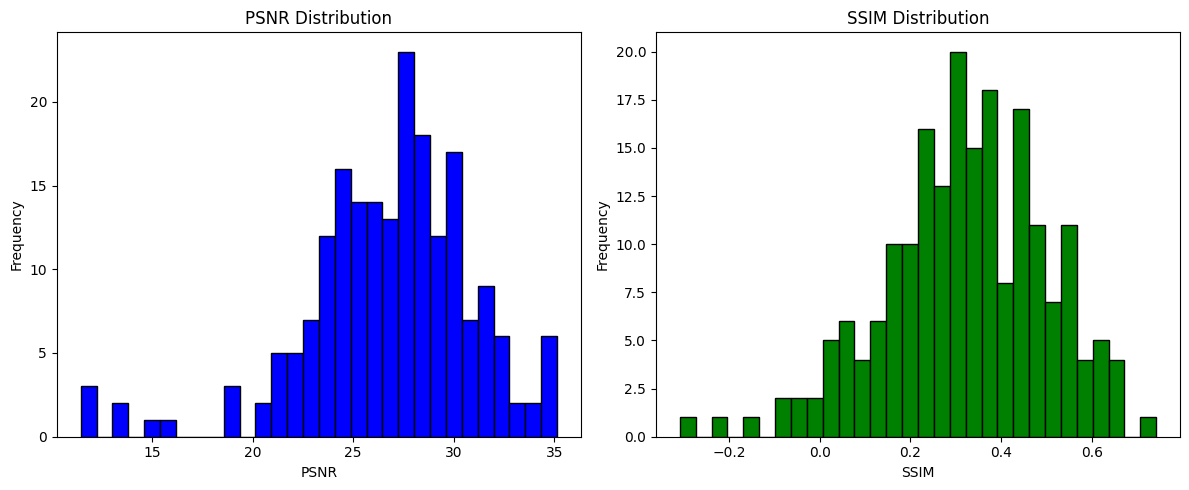

/tmp/ipykernel_227/963286482.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4311 negative Z values that have been clipped to zero
  rgb_image_pred = lab2rgb(lab_image)
/tmp/ipykernel_227/963286482.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 62037 negative Z values that have been clipped to zero
  rgb_image_pred = lab2rgb(lab_image)
/tmp/ipykernel_227/963286482.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11759 negative Z values that have been clipped to zero
  rgb_image_pred = lab2rgb(lab_image)
/tmp/ipykernel_227/963286482.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 42355 negative Z values that have been clipped to zero
  rgb_image_pred = lab2rgb(lab_image)
/tmp/ipykernel_227/963286482.py:29: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 31189 negative Z values that have been clipped to zero
  rg

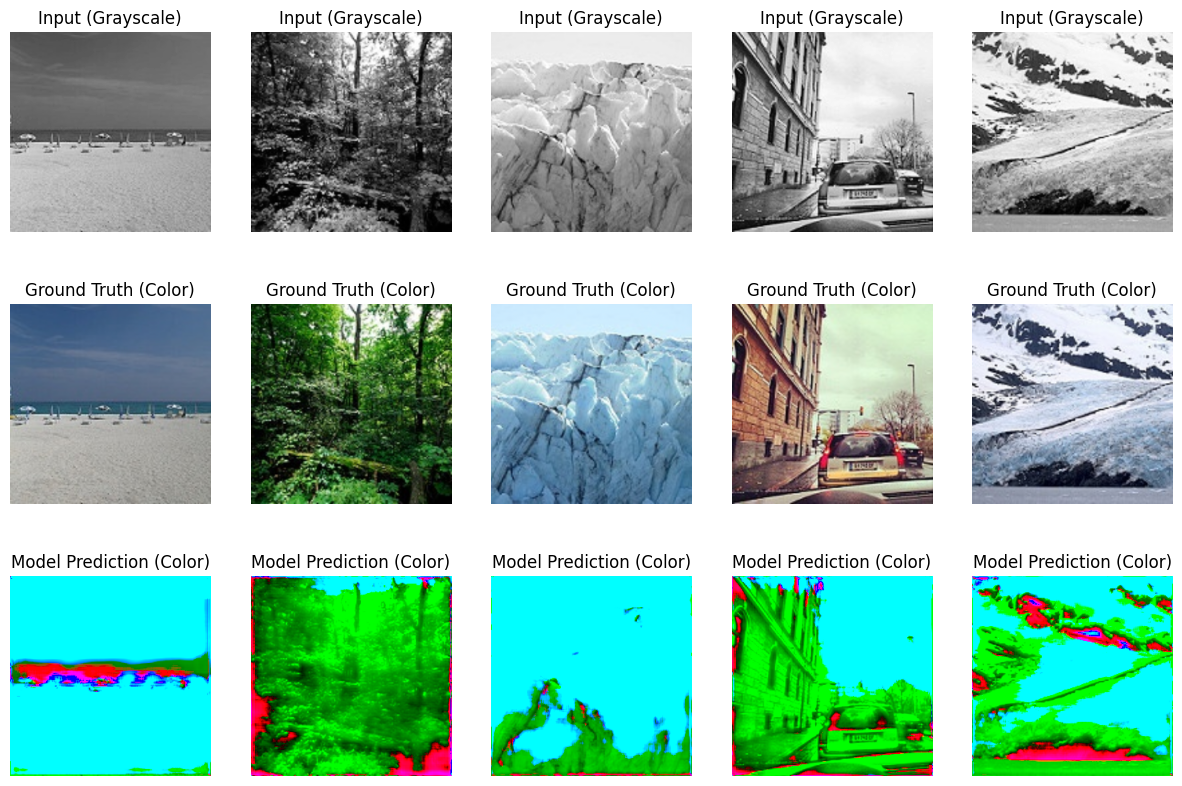

In [10]:
import matplotlib.pyplot as plt
import cv2
from skimage.color import lab2rgb

# Function to display original and colorized images
def display_images(X_val, Y_val, Y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Original grayscale image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(X_val[i], cmap='gray')
        plt.title("Input (Grayscale)")
        plt.axis("off")

        # Ground truth color image
        ax = plt.subplot(3, num_images, i + num_images + 1)
        lab_image = np.zeros((X_val[i].shape[0], X_val[i].shape[1], 3))
        lab_image[..., 0] = X_val[i] * 100
        lab_image[..., 1:] = Y_val[i] * 255 - 128
        rgb_image = lab2rgb(lab_image)
        plt.imshow(rgb_image)
        plt.title("Ground Truth (Color)")
        plt.axis("off")

        # Colorized image by model
        ax = plt.subplot(3, num_images, i + 2 * num_images + 1)
        lab_image[..., 0] = X_val[i] * 100
        lab_image[..., 1:] = Y_pred[i] * 255 - 128
        rgb_image_pred = lab2rgb(lab_image)
        plt.imshow(rgb_image_pred)
        plt.title("Model Prediction (Color)")
        plt.axis("off")
    plt.show()

# Plotting PSNR and SSIM distributions
def plot_metrics(psnr_values, ssim_values):
    plt.figure(figsize=(12, 5))
    
    # PSNR Plot
    plt.subplot(1, 2, 1)
    plt.hist(psnr_values, bins=30, color='blue', edgecolor='black')
    plt.title('PSNR Distribution')
    plt.xlabel('PSNR')
    plt.ylabel('Frequency')

    # SSIM Plot
    plt.subplot(1, 2, 2)
    plt.hist(ssim_values, bins=30, color='green', edgecolor='black')
    plt.title('SSIM Distribution')
    plt.xlabel('SSIM')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Predict on the validation data
Y_pred = model.predict(X_val[..., np.newaxis])
Y_pred = Y_pred * 255.0 - 128  # Denormalize the output
Y_val_denorm = Y_val * 255.0 - 128  # Denormalize the ground truth

# Calculate PSNR and SSIM values
psnr_values = []
ssim_values = []

for i in range(len(X_val)):
    psnr_value = psnr(Y_val_denorm[i], Y_pred[i], data_range=255)
    ssim_value = ssim(Y_val_denorm[i], Y_pred[i], data_range=255, channel_axis=-1, win_size=5)
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

# Plot metrics
plot_metrics(psnr_values, ssim_values)

# Display images
display_images(X_val, Y_val, Y_pred, num_images=5)
